In [22]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [23]:
IMAGE_SHAPE=(224,224)

In [24]:
import pathlib
data_dir=pathlib.Path("/home/sanjana/Desktop/med_img/cervical-cancer2")
data_dir

PosixPath('/home/sanjana/Desktop/med_img/cervical-cancer2')

In [25]:
image_count=len(list(data_dir.glob('*/*jpg')))
image_count

1702

In [26]:
lesions_dict={
    'NILM': list(data_dir.glob('NILM/*')),
    'LSIL': list(data_dir.glob('LSIL_new/*')),
    'HSIL': list(data_dir.glob('HSIL_new/*')),
    'SCC': list(data_dir.glob('SCC_new/*')),
}

In [27]:
len(lesions_dict['NILM'])

612

In [28]:
lesions_labels={
    'NILM': 0,
    'LSIL': 1,
    'HSIL': 2,
    'SCC': 3,
}

In [29]:
x, y=[],[]
for lesions_name, images in lesions_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        x.append(img)
        y.append(lesions_labels[lesions_name])

In [30]:
x=np.array(x)
y=np.array(y)

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [32]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255
x_val_scaled=x_val/255
print(len(x_train_scaled))
print(len(x_val_scaled))
print(len(x_test_scaled))

810
271
271


In [33]:
classifier="https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"
mod=hub.KerasLayer(classifier, input_shape=(224,224,3), trainable=False)

In [34]:
from sklearn.model_selection import KFold

In [35]:
num_lesions=4



In [36]:
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

In [37]:
import matplotlib.pyplot as plt
acc_per_fold=[]
loss_per_fold=[]
# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(x_train_scaled, y_train):
    model=tf.keras.Sequential([
        mod, 
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(num_lesions)
    ])

    model.compile(
        optimizer="adam", 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['acc'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(x_train_scaled, y_train, batch_size=20,epochs=10,callbacks = es)
    
    scores = model.evaluate(x_val_scaled, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
27/27 [==============================] - 14s 436ms/step - loss: 0.3704 - acc: 0.8568
Epoch 2/10
27/27 [==============================] - 12s 445ms/step - loss: 0.0640 - acc: 0.9840
Epoch 3/10
27/27 [==============================] - 12s 449ms/step - loss: 0.0412 - acc: 0.9840
Epoch 4/10
27/27 [==============================] - 12s 443ms/step - loss: 0.0120 - acc: 0.9963
Epoch 5/10
27/27 [==============================] - 12s 438ms/step - loss: 0.0028 - acc: 1.0000
Epoch 6/10
27/27 [==============================] - 12s 448ms/step - loss: 0.0016 - acc: 1.0000
Epoch 7/10
27/27 [==============================] - 12s 459ms/step - loss: 8.4512e-04 - acc: 1.0000
Epoch 8/10
27/27 [==============================] - 12s 449ms/step - loss: 6.3221e-04 - acc: 1.0000
Epoch 9/10
27/27 [==============================] - 12s 452ms/step - loss: 3.8240e-04 - acc: 1.0000
Epoch 10/10
27/27 [========

KeyError: 'val_acc'

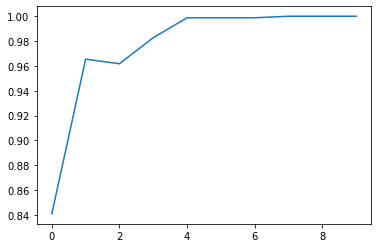

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
model.evaluate(x_test_scaled, y_test)

9/9 [==============================] - 4s 459ms/step - loss: 0.0694 - acc: 0.9668


[0.06939516961574554, 0.9667896628379822]

In [40]:
preds=model.predict(x_test_scaled)
pred_classes=np.argmax(preds, axis=1)
pred_classes

array([1, 1, 0, 0, 2, 3, 3, 0, 3, 0, 2, 2, 0, 2, 3, 0, 2, 1, 2, 2, 1, 2,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 0, 0,
       0, 1, 1, 1, 0, 0, 3, 1, 3, 3, 3, 0, 0, 0, 1, 2, 1, 1, 2, 1, 0, 0,
       3, 3, 3, 3, 2, 3, 3, 1, 0, 3, 2, 0, 0, 0, 1, 1, 0, 3, 3, 3, 0, 3,
       1, 2, 3, 0, 3, 2, 0, 3, 0, 3, 3, 2, 0, 2, 3, 2, 0, 1, 1, 0, 2, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 2, 1, 0, 0, 1,
       1, 3, 0, 3, 3, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2, 0,
       3, 2, 0, 3, 3, 3, 0, 0, 2, 0, 2, 0, 0, 3, 2, 2, 2, 0, 1, 0, 3, 0,
       3, 1, 0, 0, 0, 0, 1, 0, 2, 0, 3, 2, 2, 0, 1, 3, 0, 0, 0, 0, 2, 3,
       1, 0, 0, 0, 1, 0, 2, 0, 3, 1, 2, 3, 3, 0, 0, 0, 1, 0, 0, 2, 3, 0,
       1, 1, 3, 2, 0, 0, 1, 3, 0, 0, 3, 2, 0, 1, 1, 3, 0, 0, 1, 0, 2, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1,
       3, 0, 0, 0, 0, 2, 0])

In [41]:
class_labels=[0,1,2,3]
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, pred_classes, class_labels)
print(report) 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_classes)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       127
           1       0.94      1.00      0.97        47
           2       0.86      0.92      0.89        39
           3       1.00      0.97      0.98        58

    accuracy                           0.97       271
   macro avg       0.95      0.96      0.96       271
weighted avg       0.97      0.97      0.97       271



/home/sanjana/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


array([[123,   0,   4,   0],
       [  0,  47,   0,   0],
       [  0,   3,  36,   0],
       [  0,   0,   2,  56]])